In [1]:

import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

import wandb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import xgboost as xgb

## Load data

In [6]:
## load data.csv
c_names=["feature1_t0","feature2_t0","feature3_t0","feature1_t1","feature2_t1","feature3_t1","feature1_t2","feature2_t2","feature3_t2","score_t0","score_t1","score_t2","score","label"]
data = pd.read_csv('data.csv',names=c_names,skiprows=1)
data.head()


feature1_t0  feature2_t0  feature3_t0  feature1_t1  feature2_t1  \
0     1.275952     9.548464    20.857206    -1.640917     9.879204   
1     2.209974    11.657870    18.994037    -1.583167    11.185200   
2    -0.928405    11.057740    22.520939     1.421343    11.178265   
3     0.583430     9.428129    19.557302     0.102584     9.106648   
4     0.142398     9.179987    20.252988    -1.483179     9.365358   

   feature3_t1  feature1_t2  feature2_t2  feature3_t2   score_t0   score_t1  \
0    19.796847     1.286034     7.853225    20.916851 -12.885027 -13.454494   
1    20.050245    -0.040625    10.566484    19.212929 -11.824399 -13.999659   
2    20.241026    -0.029118    10.790355    20.340290 -11.021825 -12.921086   
3    14.846111    -1.093920    10.778970    20.884420 -15.485350 -15.343734   
4    19.794396     1.470028    12.056651    20.820639 -13.315184 -13.604042   

    score_t2      score  label  
0 -10.525529 -13.805164    1.0  
1 -11.552003 -10.581159    1.0  
2 -14.071246 -10.887280    1.0  
3 -12.313570 -14.453414    0.0  
4 -14.272901 -15.524159    0.0

## Perform EDA


In [7]:
# check for missing values
data.isnull().sum()


feature1_t0    0
feature2_t0    0
feature3_t0    0
feature1_t1    0
feature2_t1    0
feature3_t1    0
feature1_t2    0
feature2_t2    0
feature3_t2    0
score_t0       0
score_t1       0
score_t2       0
score          0
label          0
dtype: int64

In [10]:
## continue EDA
data.describe()


feature1_t0  feature2_t0  feature3_t0  feature1_t1  feature2_t1  \
count  4700.000000  4700.000000  4700.000000  4700.000000  4700.000000   
mean      2.352427    14.814628    12.794035     2.353992    14.813734   
std       1.993774     3.101333     4.330115     1.999764     3.100102   
min      -4.544016     6.318919     1.752413    -4.788809     6.068094   
25%       0.966323    12.390290     9.330333     0.972126    12.388528   
50%       2.353461    14.816391    12.763517     2.355973    14.816379   
75%       3.732465    17.236329    16.279076     3.741883    17.237191   
max       8.990426    24.721520    23.734379     8.990426    23.243075   

       feature3_t1  feature1_t2  feature2_t2  feature3_t2     score_t0  \
count  4700.000000  4700.000000  4700.000000  4700.000000  4700.000000   
mean     12.801794     2.353283    14.827257    12.802029   -18.243867   
std       4.337565     2.004035     3.106940     4.329762     3.671110   
min       1.752413    -4.788809     6.068094     1.752413   -28.711803   
25%       9.315052     0.962183    12.398733     9.309642   -21.072403   
50%      12.761450     2.353461    14.822495    12.758628   -18.266105   
75%      16.275102     3.731471    17.244627    16.284618   -15.385272   
max      23.734379     8.990426    24.897515    23.244279    -7.937269   

          score_t1     score_t2        score        label  
count  4700.000000  4700.000000  4700.000000  4700.000000  
mean    -18.469377   -18.702229   -18.930368     0.519787  
std       3.679798     3.678976     3.644913     0.499661  
min     -30.868218   -30.868218   -30.868218     0.000000  
25%     -21.282751   -21.542660   -21.737445     0.000000  
50%     -18.499260   -18.733817   -18.952174     1.000000  
75%     -15.632400   -15.891448   -16.111843     1.000000  
max      -7.937269    -8.377252    -8.377252     1.000000

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


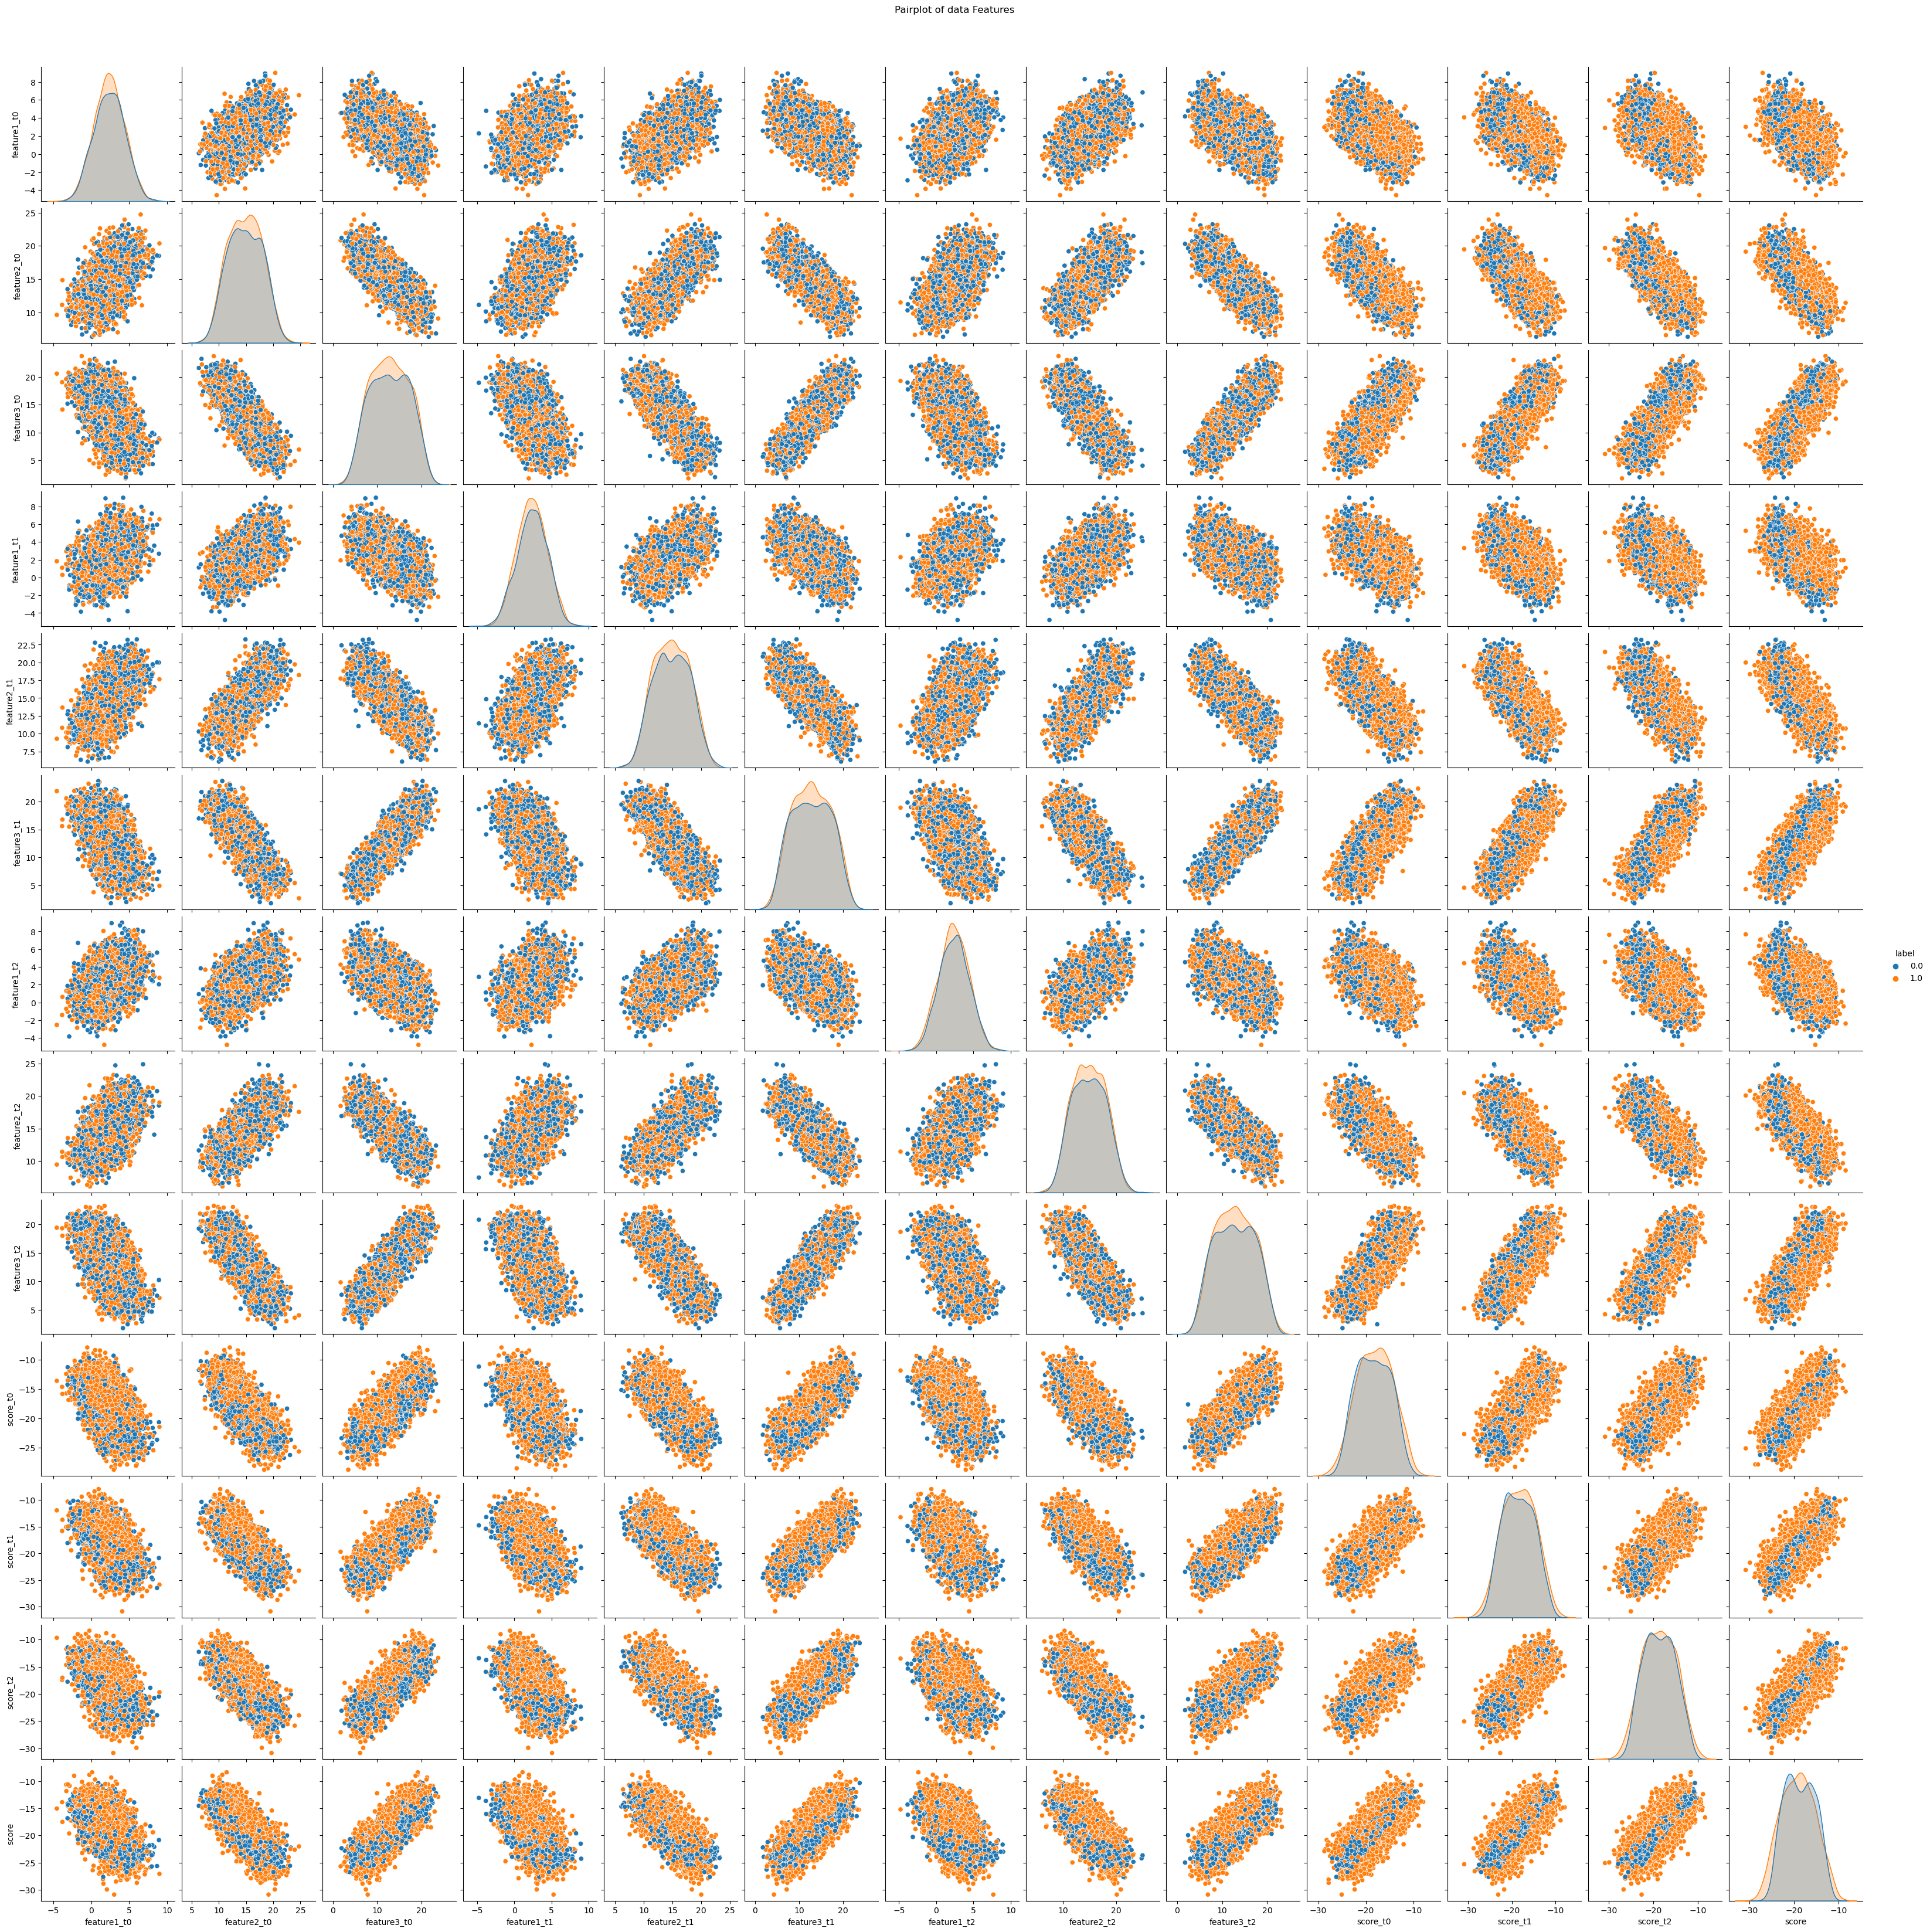

In [11]:
# Pairplot to visualize the relationships between features
sns.pairplot(data, hue='label')
plt.suptitle("Pairplot of data Features", y=1.02)
plt.show()




<Figure size 1000x800 with 0 Axes>

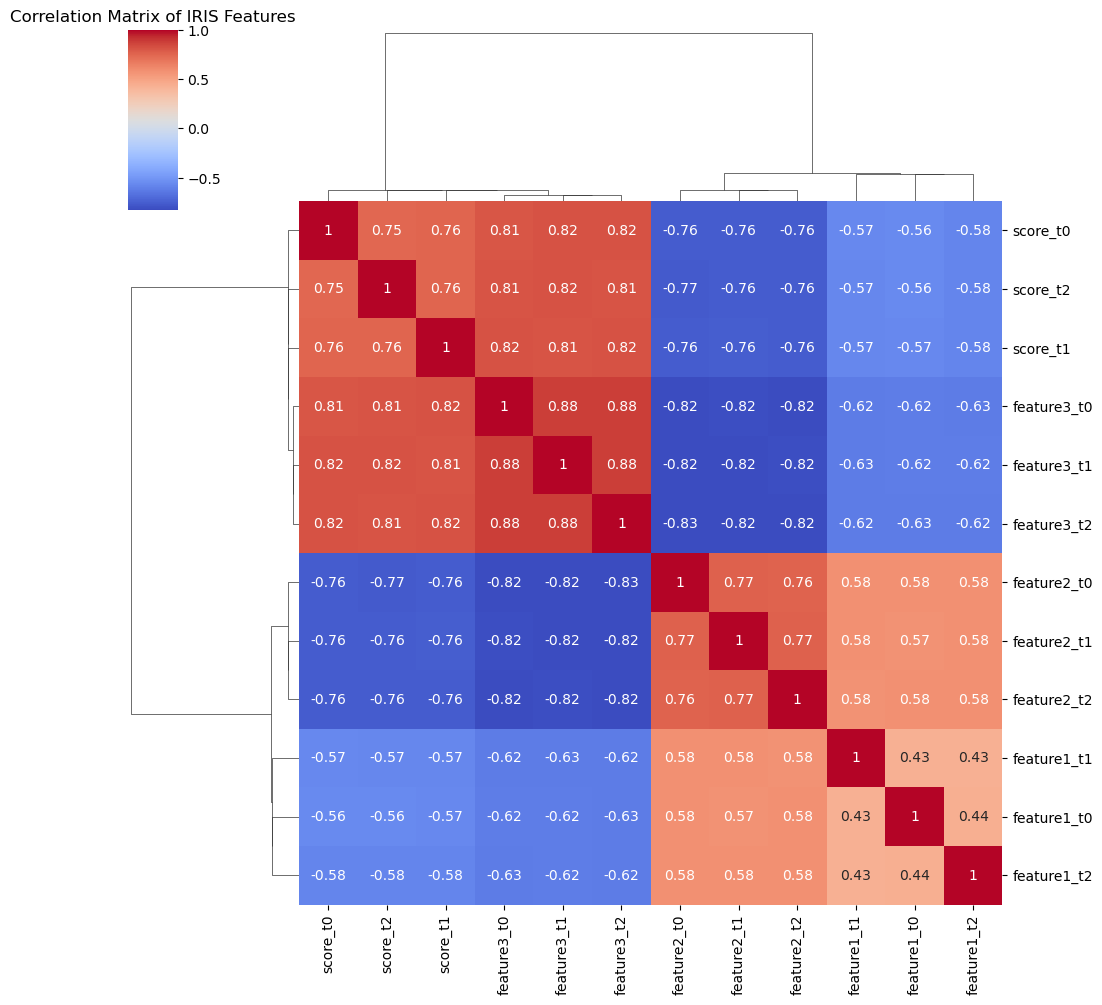

In [12]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.clustermap(data.iloc[:,:-2].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of IRIS Features")
plt.show()

In [20]:
## Split data

X = data.iloc[:,:-2]
y = data.iloc[:,-2]

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2, 
                                                    random_state=42)


In [22]:
## Train an xgboost regressor 

# Create the regressor: xgb_reg
from sklearn.metrics import mean_squared_error


xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)

# Fit the regressor to the training set
xgb_reg.fit(X_train,y_train)

# Predict the labels of the test set: preds
preds = xgb_reg.predict(X_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 1.929267


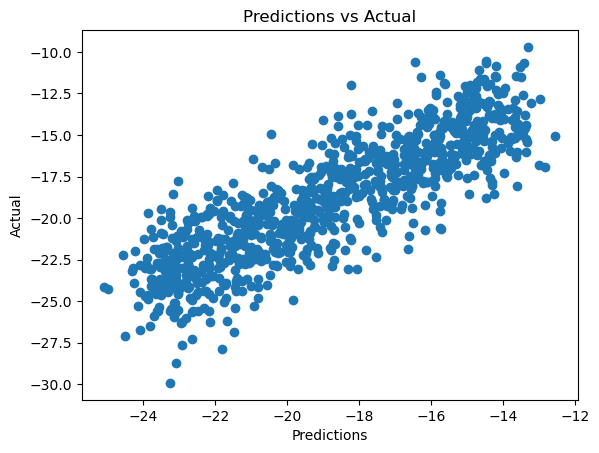

R^2: 0.726279


In [25]:
#plot the preds and y_test, show the correlation
plt.scatter(preds,y_test)

plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Predictions vs Actual')
plt.show()

#compute the R^2 score
r2 = xgb_reg.score(X_test,y_test)
print("R^2: %f" % (r2))


In [46]:
## now train a xgboost classifier
## Split data

X = data.iloc[:,:-2]
y = data.iloc[:,-1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2, 
                                                    random_state=42,stratify=y)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'max_depth': 10,  # maximum depth of each tree
    'eta': 1e-2,      # the learning rate
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class':2 }

# Number of training iterations
num_round = 200


# Training the model
bst = xgb.train(params, dtrain, num_round)

# Predicting on the test set
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

# Calculating the accuracy
accuracy = accuracy_score(y_test, best_preds)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, best_preds))


Accuracy: 0.6553191489361702
              precision    recall  f1-score   support

         0.0       0.63      0.68      0.66       451
         1.0       0.68      0.63      0.66       489

    accuracy                           0.66       940
   macro avg       0.66      0.66      0.66       940
weighted avg       0.66      0.66      0.66       940



In [31]:
# 7520/2
